In [1]:
### Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn import metrics
import tqdm
%matplotlib inline

In [2]:
#### Daily Resolution Data

if True:
    keep_col = list(range(1,18))

    df_day = pd.read_csv('Clean Data/SPX_500_Clean_Day.csv', 
                         infer_datetime_format=True,
                         parse_dates=['Timestamp'], 
                         index_col=['Timestamp'],
                         usecols = keep_col,
                         date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    #df_min.dtypes
    print (df_day.shape)
    #df_day.head(5)

(3857, 16)


In [3]:
df_day.describe()

,Open,High,Low,Close,SMA_10,SMA_50,EMA_10,EMA_50,RSI,ROC,MACD_Line,MACD_Diff,MACD_Sig,WO
count,3857.000000,3857.000000,3857.000000,3848.000000,3808.000000,3848.000000,3808.000000,3857.000000,3845.000000,3808.000000,3800.000000,3800.000000,3829.000000,3857.000000
mean,1715.086383,1697.796938,1706.935660,1705.841864,1701.374714,1705.855604,1701.565332,54.738659,0.384923,10.411685,0.055819,10.312588,55.212719,19.386009
std,602.780754,600.675619,601.709262,599.491012,590.869293,599.384149,590.621768,11.334405,3.311187,35.555153,9.181725,33.989945,10.669160,9.594660
min,695.500000,666.670000,676.610000,707.843000,788.792800,713.881525,792.685857,0.000000,-25.039539,-170.389002,-54.381042,-156.910028,21.388335,0.000000
25%,1250.050000,1234.810000,1241.990000,1243.876750,1242.609100,1244.825695,1241.914548,46.503471,-1.056311,-4.717105,-4.576509,-3.702125,47.714477,13.139599
50%,1463.760000,1449.980000,1457.420000,1452.703500,1456.224900,1453.556180,1464.552797,55.915914,0.777310,16.472578,0.467642,16.416990,55.542451,16.507645
75%,2103.480000,2088.450000,2098.110000,2093.838500,2088.807300,2092.774064,2086.490834,63.315826,2.220270,33.387991,5.243916,32.424883,63.021711,23.096805
max,3247.930000,3234.370000,3239.760000,3218.943000,3119.831800,3215.371954,3127.533669,100.000000,20.577253,111.229593,38.810383,101.875337,85.939124,65.553183


In [4]:
# create 10 years of data from 2019 - 2010
day_data = df_day[df_day.index >= '2010-01-01']

#split 7 years train, 3 years test
day_train = day_data[day_data.index <= '2017-01-01']
day_test = day_data[day_data.index >= '2017-01-01']
# create 10 years of data from 2019 - 2010
day_data = df_day[df_day.index >= '2010-01-01']

#split 7 years train, 3 years test
day_train = day_data[day_data.index <= '2017-01-01']
day_test = day_data[day_data.index >= '2017-01-01']
base_train = day_train['Close'] 
base_test = day_test['Close']

#### Fit ACF and PACF
Fitting an Autocorrelation and Partial Autocorrelation plot to help select the params for the ARIMA model that I'll use as the baseline.

ValueError: negative dimensions are not allowed

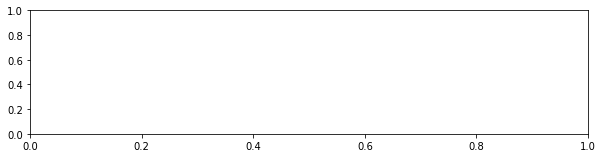

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10,5))
lags = 365
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(base_train.to_numpy(), ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(base_train.to_numpy(), ax=axis, lags=lags)
# show plot
plt.show()

ValueError: negative dimensions are not allowed

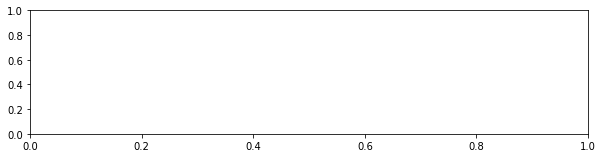

In [7]:
plt.figure(figsize=(10,5))
lags = 7
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(base_train.to_numpy(), ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(base_train.to_numpy(), ax=axis, lags=lags)
# show plot
plt.show()

Explanation of what's above. Seems to suggest a look back of no more than 2 timesteps is useful....
* Something
* Something else
* Yet something else

In [9]:
#Test Fit the ARIMA model and see what the prediction looks like

if True:
    
    model = ARIMA(base_train, order=(5,0,0))
    model_fit = model.fit(disp=1, full_output=True)
    pred = model_fit.forecast(steps=30)
    pred[0]

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: Insufficient degrees of freedom to estimate

#### Walk-Forward Validation of the ARIMA model

In order to test how the ARIMA model does over time, I'll walk the model forward 30 steps (days) at a time. The process is summarized below:
1. Split the dataset into Test/Train
2. Initialize ARIMA model
3. Fit ARIMA model to Train data
4. Predict the next 30 timesteps
5. Compare prediction with actual and calculation erros
6. Add 30 timesteps to the Train data
7. Repeat steps 1 - 6 until we've passed in the whole training set
8. Plot the prediction vs actual
9. Calculate the aggregate error for the entire prediction

In [8]:
#Inputs for Walk-Forward
X = day_data['Close']
n_train = len(base_train)
n_records = len(base_train)+len(base_test)
step = 30
predictions = list()
pred_dict = dict()
errors = list()
count = 0

#Main Loop
for i in tqdm.tqdm_notebook(np.arange(n_train, n_records, step)):
    
    #Split Data
    train, test = X[0:i], X[i:i+step]
    #train, test = X[(step*count):i], y[(count * (step-1)): ((count+1)*(step))]
    
    #Create Model
    model = ARIMA(train, order=(5,0,0))
    
    #Fit the Model
    model_fit = model.fit()
    
    #Create the Prediction
    output = model_fit.forecast(steps=30)    
    
    #Save the Output to predictions list
    predictions.append(output[0])
    
    #Create Output df that includes the day of each forecast (ie. forecast horizon)
    res = pd.DataFrame(list(range(1,31)), columns=['Day'])
    res['Pred'] = output[0]
    
    #Append the df to the pred_dict dictionary for plotting below
    pred_dict[count] = res
    
    #Calcuate Error
    #N.B. Last iteration is always diff shape we'll just calculate with what we have
    mae = metrics.mean_absolute_error(test,output[0][0:len(test)])
    rmse = metrics.mean_squared_error(test,output[0][0:len(test)])
    
    #Append Error to List
    err = [count+1, mae, rmse]
    errors.append(err)
    
    #Print Update
    print('Iteration:',count+1)
    print('MAE:',mae)
    print('RMSE:',rmse)
    
    #Increase Counter
    count += 1

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 1
MAE: 3.006074480475108
RMSE: 11.144091404577933


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 2
MAE: 1.983680348379727
RMSE: 4.604243972832664


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 3
MAE: 1.7187540288704488
RMSE: 4.923884147481318


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 4
MAE: 4.918547524716148
RMSE: 32.416912920903414


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 5
MAE: 0.8320572168832238
RMSE: 0.9219923304462397


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 6
MAE: 1.093587817337964
RMSE: 1.5100937322154018


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 7
MAE: 1.4589135086595708
RMSE: 3.1821020797093706


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 8
MAE: 2.6624485259307438
RMSE: 11.760271846803363


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 9
MAE: 1.9023343851764263
RMSE: 5.61995162181178


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 10
MAE: 5.297440822612659
RMSE: 36.77271079114376


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 11
MAE: 4.723136712405079
RMSE: 41.55967445059594


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 12
MAE: 1.307872823366091
RMSE: 2.376042763007499


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 13
MAE: 3.370244134518121
RMSE: 16.25735550556853


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 14
MAE: 5.515778826208577
RMSE: 39.87181021051246


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 15
MAE: 5.47450027390153
RMSE: 34.61661706665273


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 16
MAE: 7.175352966860844
RMSE: 73.33631012907621


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 17
MAE: 5.580959420589287
RMSE: 44.93897135523868


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 18
MAE: 9.407794673934331
RMSE: 120.94858405341866


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 19
MAE: 6.5527907077777074
RMSE: 61.226932181323946


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 20
MAE: 1.966966899840142
RMSE: 5.070752463684171


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 21
MAE: 8.787515230681413
RMSE: 107.88560946708867


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 22
MAE: 3.5026605176265604
RMSE: 21.747344973958278


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. fo

Iteration: 23
MAE: 5.930421708141936
RMSE: 56.014031974623045
Iteration: 24
MAE: 5.449741095982427
RMSE: 33.75541669570872


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 25
MAE: 3.1788973715993647
RMSE: 12.199890349745449


/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration: 26
MAE: 0.8008145429817262
RMSE: 0.9524847452594897



In [9]:
#Check the shape of the outputs from the walk forward. Perform any necessary transformations in order to visualize the results.

#predictions
#errors
#pred_dict

In [10]:
#Unravel the predictions array in order to plot the prediction vs actual

pred = np.concatenate(predictions).ravel().tolist()
#pred

In [11]:
#Create a df with datetimeindex, append the unraveled prediction to it.
#Slice the prediction to the same length as df (it'll always be longer due to train/test split)

results = pd.DataFrame(base_test)
results['Pred'] = pred[:len(results)]

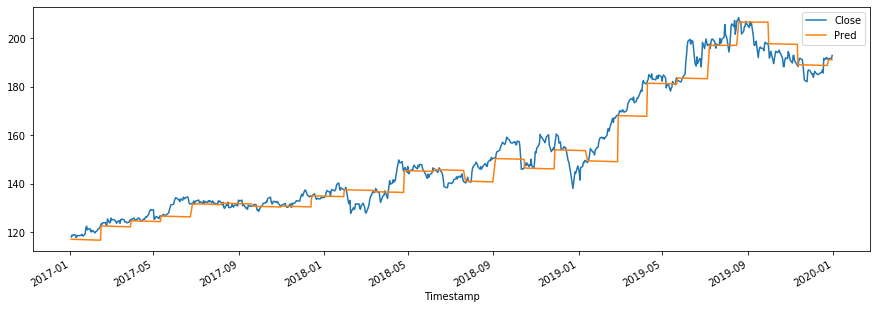

In [12]:
results.plot(figsize=(15,5))

In [13]:
#Total Error for the Walk Fowrard
total_MAE = metrics.mean_absolute_error(results['Close'], results['Pred'])
total_RMSE = metrics.mean_squared_error(results['Close'], results['Pred'])

print('Aggregate Error for the Walk Forward Validation:')
print('Mean Absolute Error:',total_MAE)
print('Mean Squared Error:',total_RMSE)

Aggregate Error for the Walk Forward Validation:
Mean Absolute Error: 4.094373234544019
Mean Squared Error: 31.225010468998526


In [14]:
# Calculate the Correlation between the Actual and Predicted Closing Price over the Test Period

results.corr(method='pearson')

,Close,Pred
Close,1.000000,0.978821
Pred,0.978821,1.000000


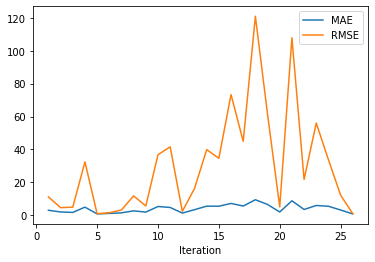

In [15]:
# Plot the Error vs Iteration (step) to see if the model increases it's accuracy over time

error_df = pd.DataFrame.from_records(errors, columns=['Iteration', 'MAE', 'RMSE'])
error_df.plot(x='Iteration', y=['MAE','RMSE'])

In [16]:
#Combine all the dfs in the pred_dict dictionary in order to plot the error by forecast horizon

combined = pd.concat(pred_dict.values(), ignore_index=True)
combined = combined[0:len(base_test.values)]
combined['Actual'] = base_test.values
#combined

In [17]:
#calculate our the error by day in the forecast

error_by_day = list()

for i in range(1,31):
    df = combined[combined.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE,err_MSE]
    error_by_day.append(error)

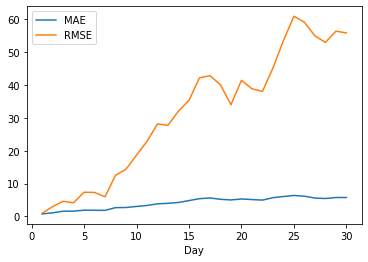

In [18]:
error_by_day = pd.DataFrame.from_records(error_by_day, columns=['Day', 'MAE', 'RMSE'])
error_by_day.plot(x='Day', y=['MAE','RMSE'])

#### Baseline Summary
* The Baseline ARIMA model has been trained and walked forward over the test set
* Model showed MAE = 4.07
* Model showed RMSE = 31.01
* The model did not show significant improvement in model accuracy with increase training set size
* As expected the model accuracy decreases with an increasing forecast horizon